**Autoencoder as Image Classifier**

In [30]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [37]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [31]:
data = pd.read_csv('mnist_train.csv')

In [32]:
data = np.array(data)
data = data[0:20000,:] # Extracting first 20000 samples
data.shape

(20000, 785)

In [33]:
#For supervised learning
class AE_Classifier(nn.Module):
  def __init__(self):
    super().__init__()

    # Input Layer

    self.input = nn.Linear(784,256)

    # Encoder Layers

    self.encoder1 = nn.Linear(256,128)
    self.encoder2 = nn.Linear(128,64)

    # Output Layer

    self.output = nn.Linear(64,10)



  def forward(self,x):

    # Input Layer

    x = F.relu( self.input(x) )

    # Encoder Layers

    x = F.relu( self.encoder1(x) )
    x = F.relu( self.encoder2(x) )

    # Output Layer

    x = self.output(x)
    return x

In [41]:
model = AE_Classifier()

In [35]:
#Extracting features and labels
X = data[:,1:]
y = data[:,0]

In [36]:
# Step 1: Convert to pytorch tensor
X_t   = torch.tensor( X, dtype = torch.float32 )
y_t = torch.tensor( y, dtype = torch.long)

# Step 2: Perform Train Test Split and Normalize the data
train_data, test_data, train_labels, test_labels = train_test_split(X_t, y_t, test_size = 0.1)

train_data = train_data/torch.max(train_data)
test_data  = test_data/torch.max(test_data)


# Step 3: Convert into PyTorch Datasets
X_train = TensorDataset(train_data,train_labels)
X_test  = TensorDataset(test_data,test_labels)


# Step 4: Move the data into dataloader objects
batchsize    = 32
train_loader = DataLoader(X_train, batch_size = batchsize, shuffle = True, drop_last=True)
test_loader  = DataLoader(X_test, batch_size = X_test.tensors[0].shape[0])

In [43]:
epochs = 50

lossfunc = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

model.to(device) # placing a model on GPU

# Initialize losses and Accuracies

losses    = torch.zeros(epochs)
trainAcc  = []
testAcc   = []


# For Loop for epochs

for epoch in range(epochs):
 model.train()

 # Loop for training in batches

 batchAcc  = []
 batchLoss = []

 for X,y in train_loader:

  X = X.to(device) # Placing features on device
  y = y.to(device) # placing labels on device

  ypred = model(X)
  loss = lossfunc(ypred,y)

# Backpropagation

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Append batchloss

  batchLoss.append(loss.item())

  ypred = ypred.cpu() # Back to cpu
  y = y.cpu()

  # compute batch accuracy

  acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == y).float())
  batchAcc.append(acc)

# Batch loop concluded

# Average training accuracy (Outside the batchloop)

 trainAcc.append(np.mean(batchAcc))

# Losses through epochs

 losses[epoch] = np.mean(batchLoss)

# TESTING the model

 model.eval()
 X,y = next(iter(test_loader))
 X = X.to(device)
 y = y.to(device)

 with torch.no_grad(): #This step is Deactivating autogradient
  ypred = model(X)
  ypred = ypred.cpu()
  y = y.cpu()

 # Appending test accuracy

  testAcc.append(100 * torch.mean((torch.argmax(ypred,dim=1)==y).float()))
  if (epoch % 10) == 0:

        print(f' epochs : {epoch}  loss : {loss}')



 epochs : 0  loss : 0.26684311032295227
 epochs : 10  loss : 0.00012191331916255876
 epochs : 20  loss : 0.0008715414442121983
 epochs : 30  loss : 2.607702498380604e-08
 epochs : 40  loss : 8.977914376373519e-07


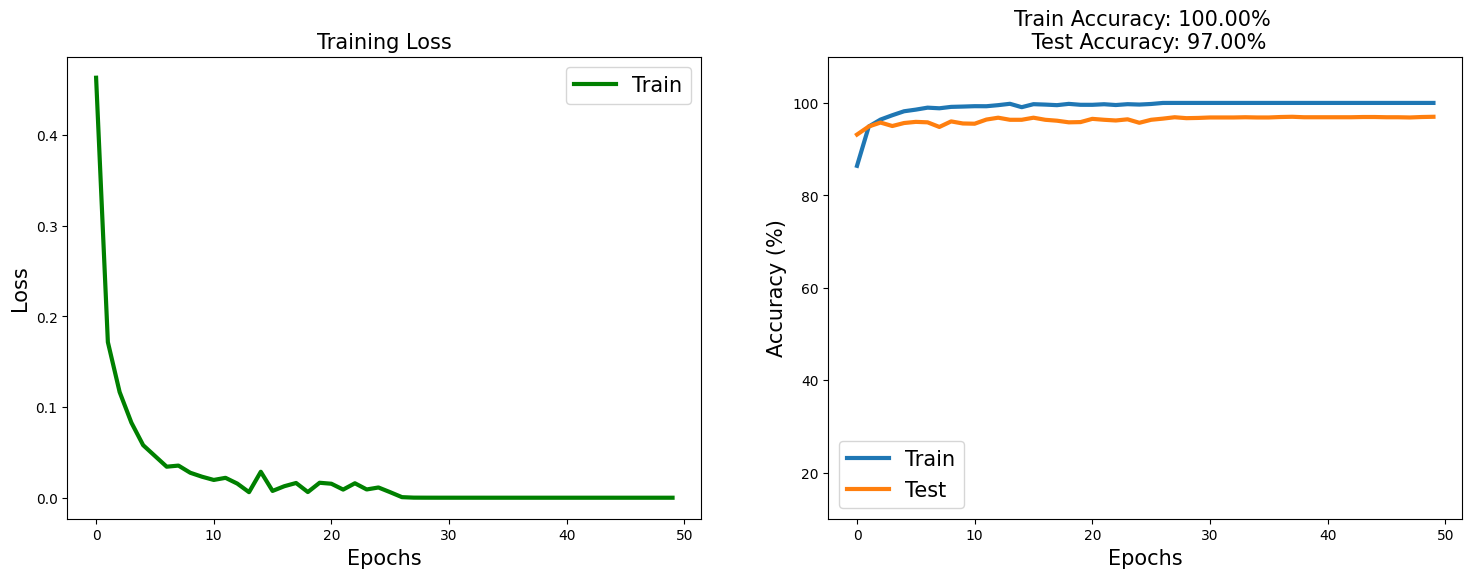

In [44]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses, 'g', lw = 3, label = 'Train')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)

ax[1].plot(trainAcc, label ='Train', lw = 3)
ax[1].plot(testAcc, label ='Test', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()